Try an extremely simple model: two circles, sampled from two populations, and try to scope out the oddities in the mixture model.

In [1]:
# needed on macs due to subtle multiprocessing differences used in dynesty
import sys
import multiprocessing
if sys.platform == 'darwin':
    multiprocessing.set_start_method('fork')

njobs = multiprocessing.cpu_count()  # might need to be modified for optimal behavior on a specific machine - e.g. computers with fast and slow cores
njobs

12

In [16]:
import math

import numpy as np
np.seterr(invalid='ignore')

from tqdm.notebook import tqdm

In [3]:
from matplotlib import pyplot as plt
from IPython.display import display
%matplotlib agg

In [4]:
def produce_uniform_circle(outerr, density):
    x, y = np.random.rand(2, int(density*4*outerr**2)) * outerr*2 - outerr
    r = np.hypot(x,y)
    msk = r< outerr
    return np.array((x[msk], y[msk]))

In [5]:
def likelihood(rinner, fouter, router, data):
    x, y = data
    r = np.hypot(x, y)
    
    innerarea = np.pi*rinner**2
    outerarea = np.pi*router**2
    lfg0 = (1-fouter)/innerarea
    lbkg0 = fouter/outerarea

    return lfg0*np.sum(r<=rinner, axis=-1)[..., np.newaxis] + lbkg0*len(r)
    

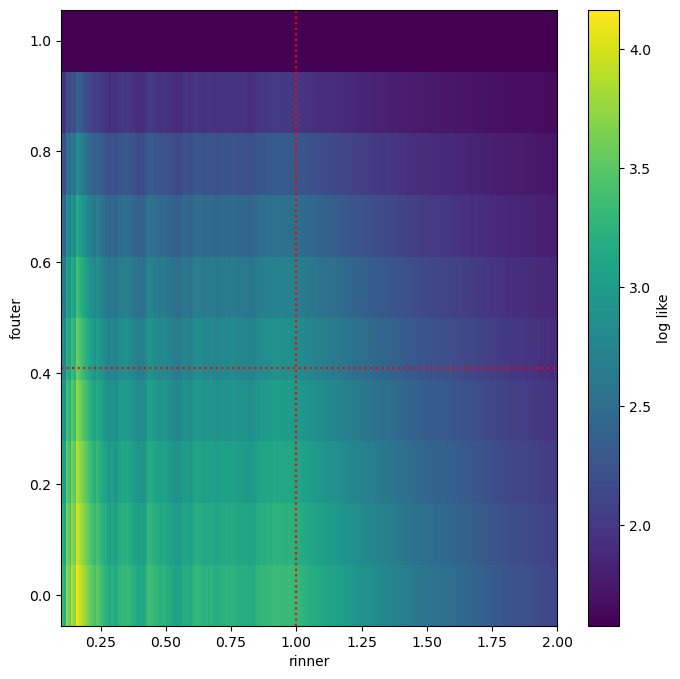

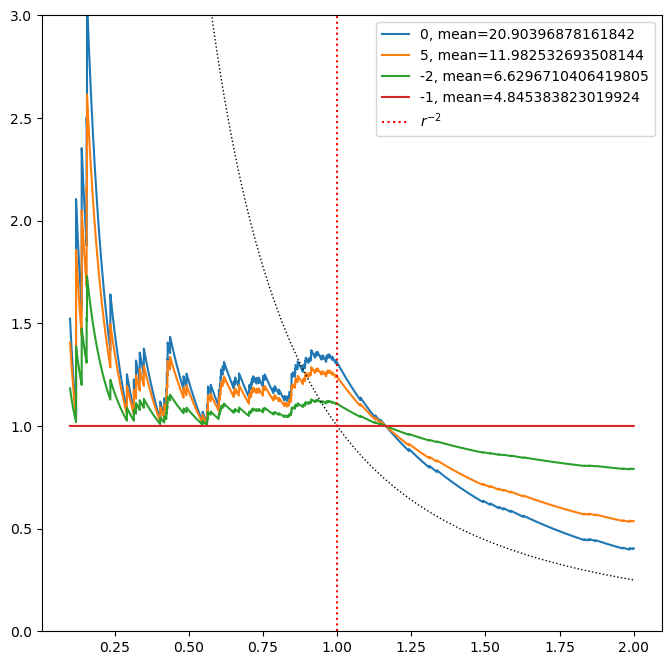

In [10]:
rinnertrue = 1
router = 3

fg = produce_uniform_circle(rinnertrue, 25)
bg = produce_uniform_circle(router, 2)
both = np.concatenate((fg, bg), axis=1)

ftrue = bg.shape[1]/both.shape[1]

ris = np.linspace(0.1, 2, 100000)
fouter = np.linspace(0, 1, 10)
rg, fgg = np.meshgrid(ris, fouter)

lg = likelihood(rg[..., np.newaxis], fgg[..., np.newaxis], router, both)[..., 0]

fig = plt.figure(figsize=(8,8))
plt.pcolor(rg, fgg, np.log(lg))
plt.axvline(rinnertrue, c='r', ls=':')
plt.axhline(ftrue, c='r', ls=':')
plt.xlabel('rinner')
plt.ylabel('fouter')
plt.colorbar().set_label('log like')
display(fig)
plt.close()


fig = plt.figure(figsize=(8,8))

for idx in [0, lg.shape[0]//2, -2, -1]:
    m = np.mean(lg[idx])
    p = plt.plot(rg[idx], lg[idx]/m, label=f'{idx}, mean={m}')
plt.plot(rg[idx], np.pi/(np.pi*rg[idx]**2), ls=':', lw=1, c='k')
plt.axvline(rinnertrue, c='r', ls=':', label='$r^{-2}$')
plt.ylim(0, 3)
plt.legend(loc=0)

display(fig)
plt.close()

While there is  a peak at the right radius, it's overwhelmed by the stocasticity in the middle. Try 10x the data

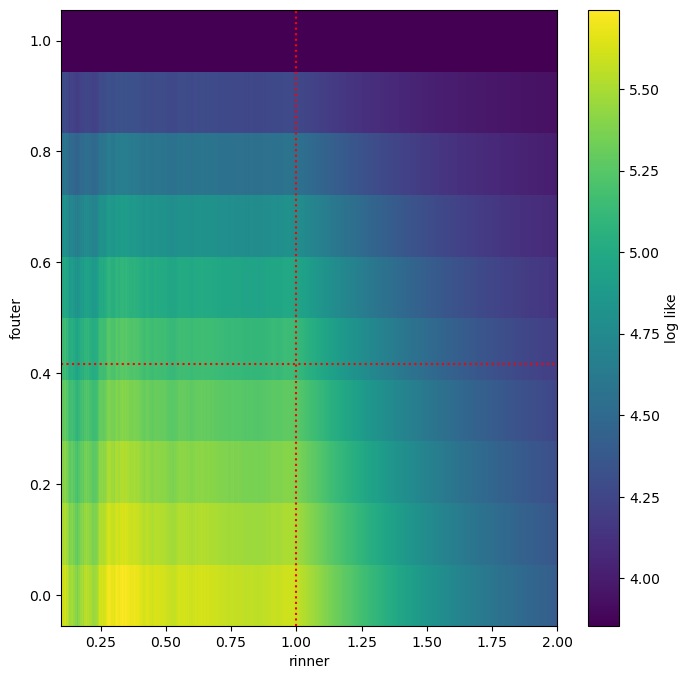

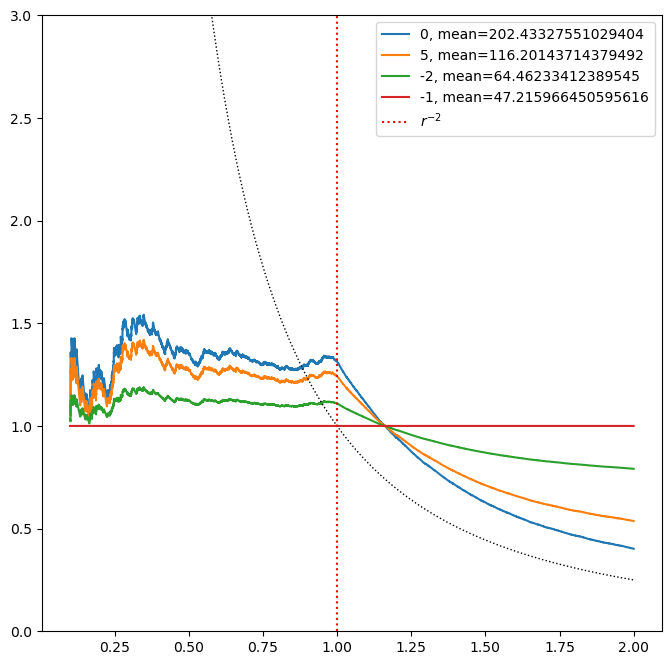

In [14]:
rinnertrue = 1
router = 3

fg = produce_uniform_circle(rinnertrue, 250)
bg = produce_uniform_circle(router, 20)
both = np.concatenate((fg, bg), axis=1)

ftrue = bg.shape[1]/both.shape[1]

ris = np.linspace(0.1, 2, 100000)
fouter = np.linspace(0, 1, 10)
rg, fgg = np.meshgrid(ris, fouter)

lg = likelihood(rg[..., np.newaxis], fgg[..., np.newaxis], router, both)[..., 0]

fig = plt.figure(figsize=(8,8))
plt.pcolor(rg, fgg, np.log(lg))
plt.axvline(rinnertrue, c='r', ls=':')
plt.axhline(ftrue, c='r', ls=':')
plt.xlabel('rinner')
plt.ylabel('fouter')
plt.colorbar().set_label('log like')
display(fig)
plt.close()


fig = plt.figure(figsize=(8,8))

for idx in [0, lg.shape[0]//2, -2, -1]:
    m = np.mean(lg[idx])
    p = plt.plot(rg[idx], lg[idx]/m, label=f'{idx}, mean={m}')
plt.plot(rg[idx], np.pi/(np.pi*rg[idx]**2), ls=':', lw=1, c='k')
plt.axvline(rinnertrue, c='r', ls=':', label='$r^{-2}$')
plt.ylim(0, 3)
plt.legend(loc=0)

display(fig)
plt.close()

Try several iterations:

  0%|          | 0/16 [00:00<?, ?it/s]

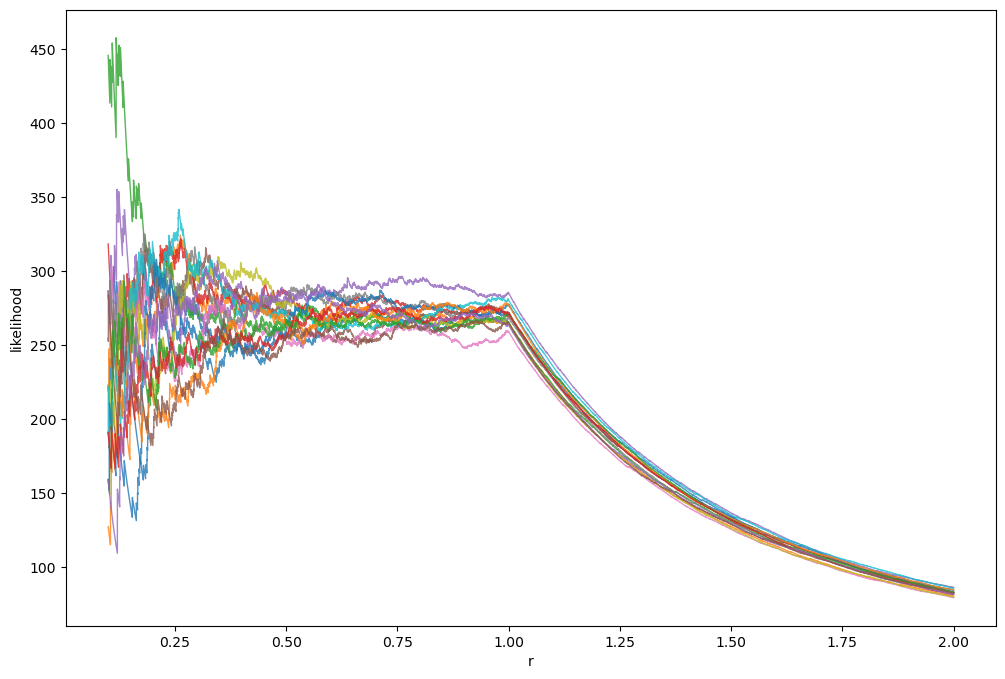

In [31]:
rinnertrue = 1
router = 3

rgs = []
lgs = []

index_to_save = 0

for _ in tqdm(list(range(16))):
    fg = produce_uniform_circle(rinnertrue, 250)
    bg = produce_uniform_circle(router, 20)
    both = np.concatenate((fg, bg), axis=1)
    
    ftrue = bg.shape[1]/both.shape[1]
    
    ris = np.linspace(0.1, 2, 100000)
    fouter = np.linspace(0, 1, 10)
    rg, fgg = np.meshgrid(ris, fouter)
    
    lg = likelihood(rg[..., np.newaxis], fgg[..., np.newaxis], router, both)[..., 0]

    rgs.append(rg[index_to_save]) 
    lgs.append(lg[index_to_save])

fig = plt.figure(figsize=(12, 8))
plt.plot(np.array(rgs).T, np.array(lgs).T, lw=1, alpha=.8)
plt.xlabel('r')
plt.ylabel('likelihood')
plt.close();fig

Hmm... the peak is not really a peak, just a falloff...